# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████| 60.0k/60.0k [04:04<00:00, 246File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

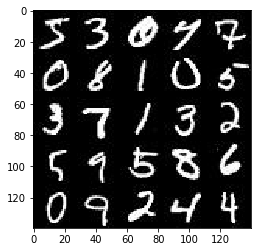

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

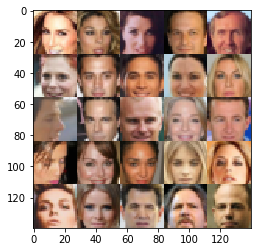

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.12.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name="inputs")
    z = tf.placeholder(tf.float32, shape=(None, z_dim), name="z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    
    return inputs, z, learning_rate

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 (faces) or 28x28x1 (mnist)
        
        # convolutional layer 1, 14x14x64. No batch normalization on this layer. Use leaky ReLU.
        conv1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        conv1 = tf.maximum(conv1, alpha * conv1)
        
        # convolutional layer 2, 7x7x128. Use batch normalization on this layer, no bias.
        conv2 = tf.layers.conv2d(conv1, 128, 5, strides=2, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(conv2, alpha * conv2)
        
        # convolutional layer 3, 3x3x256. Use batch normalization.
        conv3 = tf.layers.conv2d(conv2, 256, 5, strides=2, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(conv3, alpha * conv3)
        
        # final fully connected layer, to a single sigmoid output
        orig_shape = conv3.get_shape().as_list()
        conv3_reshaped = tf.reshape(conv3, shape=(-1, orig_shape[1] * orig_shape[2] * orig_shape[3]))
        #conv3_reshaped = tf.reshape(conv3, shape=(-1, 4*4*256)
        logits = tf.layers.dense(conv3_reshaped, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\Jack\Miniconda3\envs\jkbml\lib\site-packages\IPython\core\interactiveshell.py", line 3287, in run_code
    return outflag  File "<ipython-input-5-2e58fbd80295>", line 22, in <module>
    tests.test_model_inputs(model_inputs)  File "C:\Users\Jack\docs\code\ML\GAN_face_generation\problem_unittests.py", line 14, in func_wrapper
    return result  File "C:\Users\Jack\docs\code\ML\GAN_face_generation\problem_unittests.py", line 68, in test_model_inputs
    _check_input(learn_rate, [], 'Learning Rate')  File "C:\Users\Jack\docs\code\ML\GAN_face_generation\problem_unittests.py", line 38, in _check_input
    '{} has bad name.  Found name {}'.format(display_name, tensor.name)  File "C:\Users\Jack\d

### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        # First fully connected layer, 4x4x1024. Use batch normalization.
        x = tf.layers.dense(z, 4*4*1024, activation=None, use_bias=False)
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.reshape(tf.maximum(x, alpha * x), shape=(-1, 4, 4, 1024))
    
        # transpose convolutional layer 1, 8x8x512. Use batch normalization.
        conv1 = tf.layers.conv2d_transpose(x, 512, 5, strides=2, padding='same', use_bias=False)
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(conv1, alpha * conv1)
        
        # transpose convolutional layer 2, 16x16x256. Use batch normalization.
        conv2 = tf.layers.conv2d_transpose(conv1, 256, 5, strides=2, padding='same', use_bias=False)
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(conv2, alpha * conv2)
        
        # transpose convolutional layer 3, 32x32x128. Use batch normalization.
        conv3 = tf.layers.conv2d_transpose(conv2, 128, 5, strides=2, padding='same', use_bias=False)
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(conv3, alpha * conv3)
        
        # trim tensor to desired height and width, 28x28x128.
        trimmed = tf.slice(conv3, begin=(0, 2, 2, 0), size=(-1, 28, 28, -1))
        
        # Output layer, 28x28x(out_channel_dim)
        logits = tf.layers.conv2d(trimmed, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """

    # Get trainable variables for the discriminator and generator, respectively
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize. Use tf.control_dependencies() to ensure that batch normalization variables are updated.
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
   
    # First build the network
    
    image_channels = 1 if data_image_mode=="L" else 3
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
        
        
    # Now train it
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        batches_done = 0
        show_losses_every = 10
        show_output_every = 100
        
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):

                # rescale the input images to be between -1 and +1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})

                batches_done += 1
                
                # Generate output if needed
                
                if batches_done % show_losses_every == 0:
                    # get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if batches_done % show_output_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

               

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8257... Generator Loss: 0.7733
Epoch 1/2... Discriminator Loss: 0.1624... Generator Loss: 2.3122
Epoch 1/2... Discriminator Loss: 0.1198... Generator Loss: 2.4899
Epoch 1/2... Discriminator Loss: 0.0651... Generator Loss: 3.2764
Epoch 1/2... Discriminator Loss: 0.2265... Generator Loss: 2.0236
Epoch 1/2... Discriminator Loss: 0.0405... Generator Loss: 4.0652
Epoch 1/2... Discriminator Loss: 0.1217... Generator Loss: 2.4745
Epoch 1/2... Discriminator Loss: 0.2237... Generator Loss: 1.9823
Epoch 1/2... Discriminator Loss: 0.5459... Generator Loss: 1.7199
Epoch 1/2... Discriminator Loss: 0.6423... Generator Loss: 2.2574


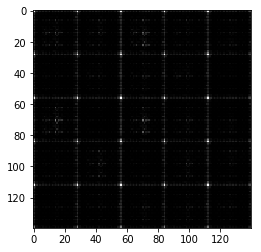

Epoch 1/2... Discriminator Loss: 0.5643... Generator Loss: 1.7869
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 1.2629
Epoch 1/2... Discriminator Loss: 0.4787... Generator Loss: 1.6002
Epoch 1/2... Discriminator Loss: 0.1842... Generator Loss: 2.7229
Epoch 1/2... Discriminator Loss: 0.1748... Generator Loss: 2.6484
Epoch 1/2... Discriminator Loss: 1.3304... Generator Loss: 0.8860
Epoch 1/2... Discriminator Loss: 0.4911... Generator Loss: 2.0011
Epoch 1/2... Discriminator Loss: 0.5462... Generator Loss: 1.3705
Epoch 1/2... Discriminator Loss: 0.3709... Generator Loss: 1.8118
Epoch 1/2... Discriminator Loss: 0.3483... Generator Loss: 2.3152


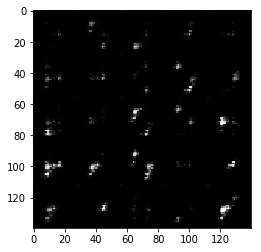

Epoch 1/2... Discriminator Loss: 0.7796... Generator Loss: 1.1687
Epoch 1/2... Discriminator Loss: 0.9757... Generator Loss: 1.3864
Epoch 1/2... Discriminator Loss: 0.8800... Generator Loss: 0.8782
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.2374
Epoch 1/2... Discriminator Loss: 1.2061... Generator Loss: 0.7869
Epoch 1/2... Discriminator Loss: 0.5572... Generator Loss: 1.5399
Epoch 1/2... Discriminator Loss: 1.5738... Generator Loss: 0.8705
Epoch 1/2... Discriminator Loss: 1.0547... Generator Loss: 0.8753
Epoch 1/2... Discriminator Loss: 1.1992... Generator Loss: 0.9036
Epoch 1/2... Discriminator Loss: 1.2586... Generator Loss: 0.5036


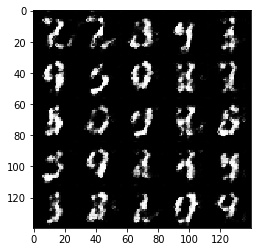

Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 1.5926
Epoch 1/2... Discriminator Loss: 1.0743... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.1162... Generator Loss: 0.8879
Epoch 1/2... Discriminator Loss: 1.2255... Generator Loss: 0.6859
Epoch 1/2... Discriminator Loss: 1.0457... Generator Loss: 1.0443
Epoch 1/2... Discriminator Loss: 1.2165... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.1111... Generator Loss: 0.9690
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.7730
Epoch 1/2... Discriminator Loss: 0.9948... Generator Loss: 0.8629


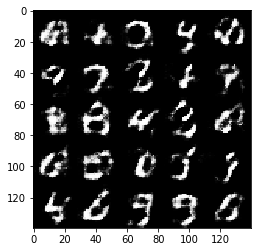

Epoch 1/2... Discriminator Loss: 1.3728... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 0.9346... Generator Loss: 1.0657
Epoch 1/2... Discriminator Loss: 1.1802... Generator Loss: 0.7585
Epoch 1/2... Discriminator Loss: 1.5159... Generator Loss: 0.5244
Epoch 1/2... Discriminator Loss: 1.1204... Generator Loss: 0.8751
Epoch 1/2... Discriminator Loss: 1.4691... Generator Loss: 0.6629
Epoch 1/2... Discriminator Loss: 1.0047... Generator Loss: 0.7619
Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.0604... Generator Loss: 1.0570
Epoch 1/2... Discriminator Loss: 1.0893... Generator Loss: 0.8746


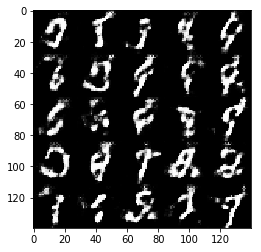

Epoch 1/2... Discriminator Loss: 1.4190... Generator Loss: 0.7081
Epoch 1/2... Discriminator Loss: 1.2124... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.1267... Generator Loss: 0.7648
Epoch 1/2... Discriminator Loss: 1.1161... Generator Loss: 1.1150
Epoch 1/2... Discriminator Loss: 1.2587... Generator Loss: 0.8362
Epoch 1/2... Discriminator Loss: 1.1145... Generator Loss: 0.8874
Epoch 1/2... Discriminator Loss: 1.0800... Generator Loss: 1.0278
Epoch 1/2... Discriminator Loss: 1.2010... Generator Loss: 1.1231
Epoch 1/2... Discriminator Loss: 1.3083... Generator Loss: 0.5591


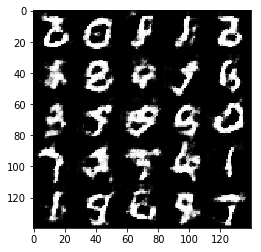

Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.7254
Epoch 1/2... Discriminator Loss: 1.1237... Generator Loss: 0.7636
Epoch 1/2... Discriminator Loss: 1.2774... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 1.2225... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.0677... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 0.7390
Epoch 1/2... Discriminator Loss: 1.2152... Generator Loss: 0.8306
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 0.6688
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 0.4589
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.1010


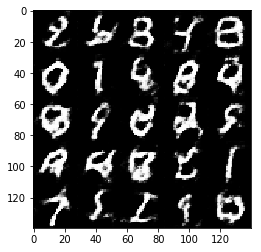

Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.5262
Epoch 1/2... Discriminator Loss: 1.2101... Generator Loss: 0.6292
Epoch 1/2... Discriminator Loss: 1.2326... Generator Loss: 0.6852
Epoch 1/2... Discriminator Loss: 1.1303... Generator Loss: 0.7740
Epoch 1/2... Discriminator Loss: 1.0973... Generator Loss: 0.9760
Epoch 1/2... Discriminator Loss: 0.8401... Generator Loss: 1.1979
Epoch 1/2... Discriminator Loss: 1.2788... Generator Loss: 0.8454
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 0.7778
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.4193... Generator Loss: 0.4306


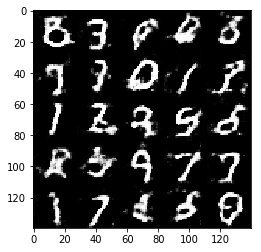

Epoch 1/2... Discriminator Loss: 1.0788... Generator Loss: 0.9897
Epoch 1/2... Discriminator Loss: 1.2635... Generator Loss: 0.7989
Epoch 1/2... Discriminator Loss: 1.5118... Generator Loss: 0.3985
Epoch 1/2... Discriminator Loss: 1.0034... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 1.0980... Generator Loss: 0.8063
Epoch 1/2... Discriminator Loss: 1.2115... Generator Loss: 0.7801
Epoch 1/2... Discriminator Loss: 1.2289... Generator Loss: 0.6290
Epoch 1/2... Discriminator Loss: 1.3981... Generator Loss: 0.4335
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 0.7145
Epoch 1/2... Discriminator Loss: 1.1173... Generator Loss: 0.9795


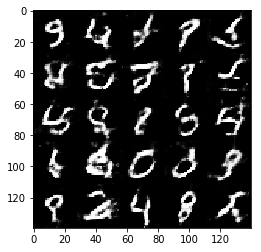

Epoch 1/2... Discriminator Loss: 1.1080... Generator Loss: 0.9970
Epoch 1/2... Discriminator Loss: 1.2518... Generator Loss: 0.7637
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.2123... Generator Loss: 0.7998
Epoch 1/2... Discriminator Loss: 1.0905... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.1092... Generator Loss: 0.8503
Epoch 1/2... Discriminator Loss: 1.3985... Generator Loss: 0.5560
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.8281
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 0.7673
Epoch 1/2... Discriminator Loss: 1.2064... Generator Loss: 0.6338


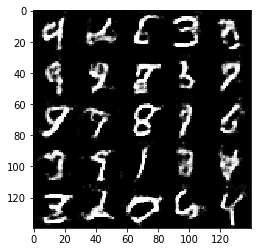

Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.5293
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.7883
Epoch 1/2... Discriminator Loss: 1.1418... Generator Loss: 0.6932
Epoch 1/2... Discriminator Loss: 1.2290... Generator Loss: 0.7884
Epoch 1/2... Discriminator Loss: 1.1087... Generator Loss: 0.7626
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.6416
Epoch 1/2... Discriminator Loss: 1.1612... Generator Loss: 0.8075
Epoch 1/2... Discriminator Loss: 1.2231... Generator Loss: 0.8539
Epoch 1/2... Discriminator Loss: 1.1733... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.4726... Generator Loss: 0.3667


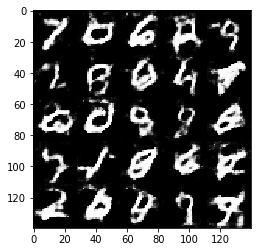

Epoch 1/2... Discriminator Loss: 1.2461... Generator Loss: 0.6240
Epoch 1/2... Discriminator Loss: 1.1174... Generator Loss: 1.0998
Epoch 1/2... Discriminator Loss: 0.9686... Generator Loss: 0.9335
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.5673
Epoch 1/2... Discriminator Loss: 1.1637... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.1065
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.0599
Epoch 1/2... Discriminator Loss: 1.0794... Generator Loss: 0.7978
Epoch 1/2... Discriminator Loss: 1.2895... Generator Loss: 0.7501
Epoch 1/2... Discriminator Loss: 1.0414... Generator Loss: 0.8599


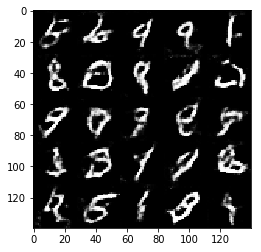

Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 0.7498
Epoch 1/2... Discriminator Loss: 1.1404... Generator Loss: 0.8578
Epoch 1/2... Discriminator Loss: 1.3531... Generator Loss: 0.6510
Epoch 1/2... Discriminator Loss: 1.0776... Generator Loss: 0.8588
Epoch 1/2... Discriminator Loss: 1.1363... Generator Loss: 0.6743
Epoch 1/2... Discriminator Loss: 1.1573... Generator Loss: 0.6871
Epoch 1/2... Discriminator Loss: 1.1730... Generator Loss: 0.6160
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.7197
Epoch 1/2... Discriminator Loss: 1.1151... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.0495... Generator Loss: 0.9697


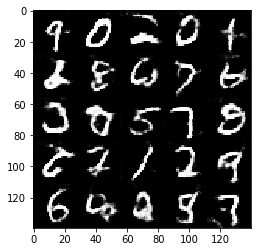

Epoch 1/2... Discriminator Loss: 1.0759... Generator Loss: 1.0362
Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.5564
Epoch 1/2... Discriminator Loss: 1.2868... Generator Loss: 0.5166
Epoch 1/2... Discriminator Loss: 1.1095... Generator Loss: 0.8724
Epoch 1/2... Discriminator Loss: 1.2319... Generator Loss: 0.6610
Epoch 1/2... Discriminator Loss: 1.1924... Generator Loss: 0.7445
Epoch 1/2... Discriminator Loss: 1.1536... Generator Loss: 0.7418
Epoch 1/2... Discriminator Loss: 1.1846... Generator Loss: 0.6281
Epoch 1/2... Discriminator Loss: 1.1599... Generator Loss: 0.6197
Epoch 1/2... Discriminator Loss: 1.3503... Generator Loss: 0.5410


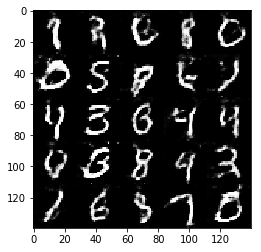

Epoch 1/2... Discriminator Loss: 1.2940... Generator Loss: 0.9763
Epoch 1/2... Discriminator Loss: 1.0961... Generator Loss: 1.1369
Epoch 1/2... Discriminator Loss: 1.1726... Generator Loss: 0.8460
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.8527
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.9116
Epoch 1/2... Discriminator Loss: 1.3586... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.2515... Generator Loss: 0.6706
Epoch 1/2... Discriminator Loss: 1.0411... Generator Loss: 0.8778
Epoch 1/2... Discriminator Loss: 1.2987... Generator Loss: 0.5669
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 0.7781


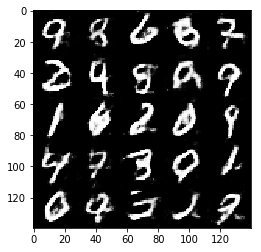

Epoch 1/2... Discriminator Loss: 1.2765... Generator Loss: 0.4777
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 1.1456
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.5443
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.1687
Epoch 1/2... Discriminator Loss: 1.2701... Generator Loss: 0.5110
Epoch 1/2... Discriminator Loss: 1.2621... Generator Loss: 0.9476
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 1.0105
Epoch 1/2... Discriminator Loss: 1.2888... Generator Loss: 0.6382
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.2219... Generator Loss: 0.8072


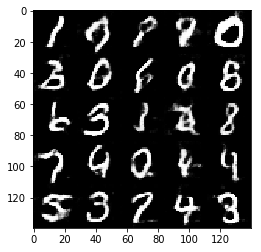

Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.6178
Epoch 1/2... Discriminator Loss: 1.0448... Generator Loss: 0.9126
Epoch 1/2... Discriminator Loss: 1.2593... Generator Loss: 0.4572
Epoch 1/2... Discriminator Loss: 0.9869... Generator Loss: 0.7858
Epoch 1/2... Discriminator Loss: 1.4251... Generator Loss: 0.3975
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.5756
Epoch 1/2... Discriminator Loss: 0.8376... Generator Loss: 1.1173
Epoch 1/2... Discriminator Loss: 1.2408... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 0.8612... Generator Loss: 0.9722


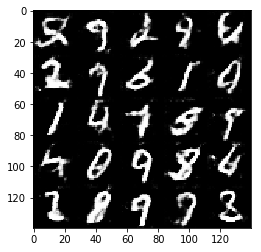

Epoch 1/2... Discriminator Loss: 0.8055... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 0.6995... Generator Loss: 1.2864
Epoch 1/2... Discriminator Loss: 1.1651... Generator Loss: 0.9668
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 0.9767... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.5278
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 0.7757
Epoch 1/2... Discriminator Loss: 1.1529... Generator Loss: 0.8640
Epoch 1/2... Discriminator Loss: 1.0364... Generator Loss: 0.9748
Epoch 1/2... Discriminator Loss: 1.0441... Generator Loss: 0.8448


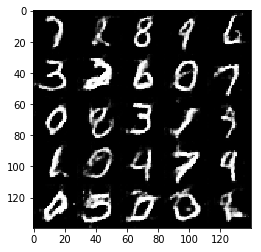

Epoch 1/2... Discriminator Loss: 1.4323... Generator Loss: 0.4029
Epoch 1/2... Discriminator Loss: 1.0912... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.3196... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 1.2236... Generator Loss: 0.6592
Epoch 1/2... Discriminator Loss: 1.1288... Generator Loss: 0.6531
Epoch 1/2... Discriminator Loss: 1.4399... Generator Loss: 0.4295
Epoch 1/2... Discriminator Loss: 1.1182... Generator Loss: 0.8197
Epoch 2/2... Discriminator Loss: 1.0417... Generator Loss: 0.8971
Epoch 2/2... Discriminator Loss: 1.0272... Generator Loss: 0.9847
Epoch 2/2... Discriminator Loss: 0.9194... Generator Loss: 1.1704


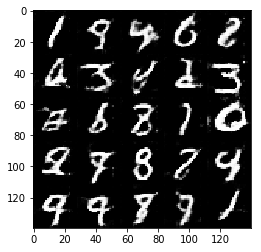

Epoch 2/2... Discriminator Loss: 1.3225... Generator Loss: 0.5483
Epoch 2/2... Discriminator Loss: 1.2271... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.2565... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.2665... Generator Loss: 0.8641
Epoch 2/2... Discriminator Loss: 1.0563... Generator Loss: 0.7582
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.7758
Epoch 2/2... Discriminator Loss: 1.3654... Generator Loss: 0.4544
Epoch 2/2... Discriminator Loss: 1.1820... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.0013... Generator Loss: 0.8833
Epoch 2/2... Discriminator Loss: 1.2621... Generator Loss: 0.6352


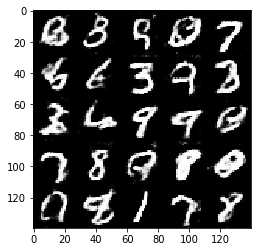

Epoch 2/2... Discriminator Loss: 1.0020... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 0.9909... Generator Loss: 1.1320
Epoch 2/2... Discriminator Loss: 1.1166... Generator Loss: 0.5884
Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 0.9703
Epoch 2/2... Discriminator Loss: 1.4215... Generator Loss: 0.4302
Epoch 2/2... Discriminator Loss: 1.0866... Generator Loss: 0.9592
Epoch 2/2... Discriminator Loss: 1.0793... Generator Loss: 0.9952
Epoch 2/2... Discriminator Loss: 1.3559... Generator Loss: 0.4689
Epoch 2/2... Discriminator Loss: 1.1752... Generator Loss: 0.5711
Epoch 2/2... Discriminator Loss: 1.1455... Generator Loss: 0.6623


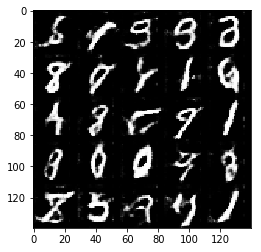

Epoch 2/2... Discriminator Loss: 1.1174... Generator Loss: 0.6786
Epoch 2/2... Discriminator Loss: 1.2587... Generator Loss: 0.7330
Epoch 2/2... Discriminator Loss: 0.9862... Generator Loss: 0.7927
Epoch 2/2... Discriminator Loss: 1.1044... Generator Loss: 0.8782
Epoch 2/2... Discriminator Loss: 1.3118... Generator Loss: 0.5480
Epoch 2/2... Discriminator Loss: 1.2743... Generator Loss: 0.4624
Epoch 2/2... Discriminator Loss: 1.1944... Generator Loss: 1.0866
Epoch 2/2... Discriminator Loss: 1.2266... Generator Loss: 0.5736
Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.6552
Epoch 2/2... Discriminator Loss: 1.2424... Generator Loss: 0.6356


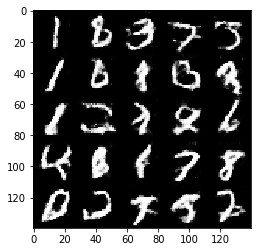

Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.4481
Epoch 2/2... Discriminator Loss: 0.9575... Generator Loss: 0.7173
Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 0.9528... Generator Loss: 0.9210
Epoch 2/2... Discriminator Loss: 1.1254... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.2257... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.9617
Epoch 2/2... Discriminator Loss: 1.1648... Generator Loss: 0.5874
Epoch 2/2... Discriminator Loss: 1.2078... Generator Loss: 0.5673
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.7204


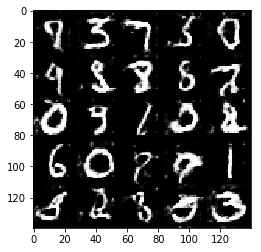

Epoch 2/2... Discriminator Loss: 1.2026... Generator Loss: 1.1533
Epoch 2/2... Discriminator Loss: 1.6031... Generator Loss: 0.3232
Epoch 2/2... Discriminator Loss: 1.2876... Generator Loss: 0.4808
Epoch 2/2... Discriminator Loss: 1.2314... Generator Loss: 0.8100
Epoch 2/2... Discriminator Loss: 1.0372... Generator Loss: 0.7585
Epoch 2/2... Discriminator Loss: 1.1896... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 1.0705... Generator Loss: 0.7890
Epoch 2/2... Discriminator Loss: 1.2403... Generator Loss: 0.6181
Epoch 2/2... Discriminator Loss: 1.1200... Generator Loss: 1.0063
Epoch 2/2... Discriminator Loss: 1.3863... Generator Loss: 0.4094


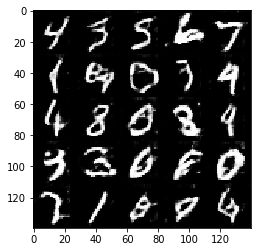

Epoch 2/2... Discriminator Loss: 1.1014... Generator Loss: 1.1280
Epoch 2/2... Discriminator Loss: 1.0828... Generator Loss: 0.9884
Epoch 2/2... Discriminator Loss: 1.2871... Generator Loss: 0.5350
Epoch 2/2... Discriminator Loss: 1.2764... Generator Loss: 0.9701
Epoch 2/2... Discriminator Loss: 1.1340... Generator Loss: 0.6970
Epoch 2/2... Discriminator Loss: 1.1093... Generator Loss: 0.6745
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.6617
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.8098
Epoch 2/2... Discriminator Loss: 1.1477... Generator Loss: 0.6622
Epoch 2/2... Discriminator Loss: 1.3510... Generator Loss: 0.9245


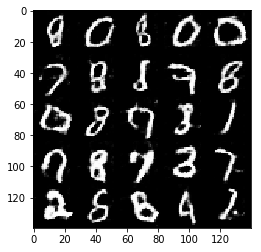

Epoch 2/2... Discriminator Loss: 1.7413... Generator Loss: 1.5003
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.7080
Epoch 2/2... Discriminator Loss: 1.2086... Generator Loss: 0.8587
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 0.9446
Epoch 2/2... Discriminator Loss: 1.0842... Generator Loss: 0.6652
Epoch 2/2... Discriminator Loss: 1.1842... Generator Loss: 0.6051
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 0.9903... Generator Loss: 1.0482
Epoch 2/2... Discriminator Loss: 1.2288... Generator Loss: 0.5586
Epoch 2/2... Discriminator Loss: 1.0088... Generator Loss: 0.8014


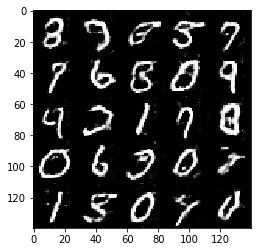

Epoch 2/2... Discriminator Loss: 0.9348... Generator Loss: 0.9740
Epoch 2/2... Discriminator Loss: 1.5272... Generator Loss: 0.3401
Epoch 2/2... Discriminator Loss: 1.0688... Generator Loss: 0.8053
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 0.6255
Epoch 2/2... Discriminator Loss: 1.1235... Generator Loss: 0.7950
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 0.6128
Epoch 2/2... Discriminator Loss: 1.2575... Generator Loss: 0.5236
Epoch 2/2... Discriminator Loss: 1.0446... Generator Loss: 1.1591
Epoch 2/2... Discriminator Loss: 1.2238... Generator Loss: 0.4991
Epoch 2/2... Discriminator Loss: 1.2388... Generator Loss: 0.6328


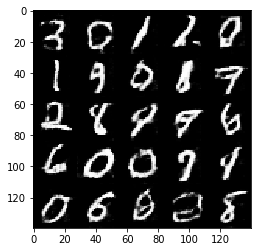

Epoch 2/2... Discriminator Loss: 1.1787... Generator Loss: 0.5282
Epoch 2/2... Discriminator Loss: 1.5721... Generator Loss: 0.3079
Epoch 2/2... Discriminator Loss: 1.3391... Generator Loss: 0.4277
Epoch 2/2... Discriminator Loss: 1.2073... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 1.0845... Generator Loss: 0.5934
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 0.3508
Epoch 2/2... Discriminator Loss: 0.9843... Generator Loss: 0.9185
Epoch 2/2... Discriminator Loss: 1.0837... Generator Loss: 1.1398
Epoch 2/2... Discriminator Loss: 1.0722... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 1.3394... Generator Loss: 0.5323


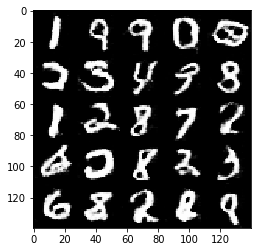

Epoch 2/2... Discriminator Loss: 1.1148... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.1588... Generator Loss: 0.9078
Epoch 2/2... Discriminator Loss: 1.0534... Generator Loss: 0.9290
Epoch 2/2... Discriminator Loss: 1.2158... Generator Loss: 0.6202
Epoch 2/2... Discriminator Loss: 1.1142... Generator Loss: 0.7170
Epoch 2/2... Discriminator Loss: 1.1372... Generator Loss: 0.5796
Epoch 2/2... Discriminator Loss: 1.2792... Generator Loss: 0.5307
Epoch 2/2... Discriminator Loss: 0.9335... Generator Loss: 0.8153
Epoch 2/2... Discriminator Loss: 1.1085... Generator Loss: 0.8308
Epoch 2/2... Discriminator Loss: 1.1802... Generator Loss: 0.8374


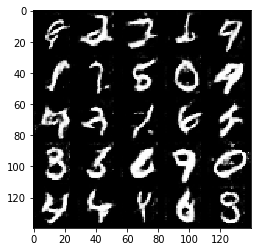

Epoch 2/2... Discriminator Loss: 0.9465... Generator Loss: 1.2380
Epoch 2/2... Discriminator Loss: 1.0954... Generator Loss: 0.7706
Epoch 2/2... Discriminator Loss: 0.8625... Generator Loss: 1.0155
Epoch 2/2... Discriminator Loss: 1.0760... Generator Loss: 0.8008
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 0.9801... Generator Loss: 0.7919
Epoch 2/2... Discriminator Loss: 1.0655... Generator Loss: 0.6374
Epoch 2/2... Discriminator Loss: 1.3887... Generator Loss: 0.4487
Epoch 2/2... Discriminator Loss: 1.0955... Generator Loss: 0.5639
Epoch 2/2... Discriminator Loss: 0.9547... Generator Loss: 1.0102


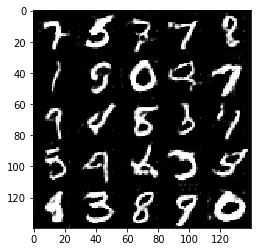

Epoch 2/2... Discriminator Loss: 1.2457... Generator Loss: 0.6577
Epoch 2/2... Discriminator Loss: 1.3130... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.1220... Generator Loss: 0.7799
Epoch 2/2... Discriminator Loss: 1.2460... Generator Loss: 0.5722
Epoch 2/2... Discriminator Loss: 1.1019... Generator Loss: 0.6695
Epoch 2/2... Discriminator Loss: 0.7899... Generator Loss: 1.0234
Epoch 2/2... Discriminator Loss: 0.9734... Generator Loss: 0.7053
Epoch 2/2... Discriminator Loss: 1.2412... Generator Loss: 0.5954
Epoch 2/2... Discriminator Loss: 1.4414... Generator Loss: 0.4124
Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.7584


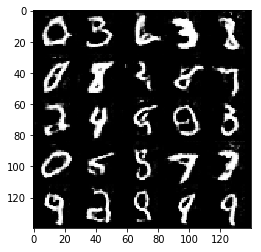

Epoch 2/2... Discriminator Loss: 0.9957... Generator Loss: 1.0422
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.7322
Epoch 2/2... Discriminator Loss: 1.3332... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 1.5214... Generator Loss: 0.3642
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.6470
Epoch 2/2... Discriminator Loss: 1.1602... Generator Loss: 0.6183
Epoch 2/2... Discriminator Loss: 1.2839... Generator Loss: 0.8034
Epoch 2/2... Discriminator Loss: 1.3592... Generator Loss: 0.7429
Epoch 2/2... Discriminator Loss: 1.0628... Generator Loss: 0.9430
Epoch 2/2... Discriminator Loss: 0.8681... Generator Loss: 1.1460


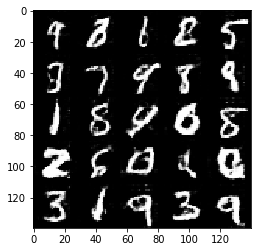

Epoch 2/2... Discriminator Loss: 1.0836... Generator Loss: 0.8123
Epoch 2/2... Discriminator Loss: 1.2620... Generator Loss: 0.9050
Epoch 2/2... Discriminator Loss: 1.4465... Generator Loss: 0.5244
Epoch 2/2... Discriminator Loss: 0.9908... Generator Loss: 1.0255
Epoch 2/2... Discriminator Loss: 1.0532... Generator Loss: 0.9902
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 0.5037
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.6251
Epoch 2/2... Discriminator Loss: 1.4063... Generator Loss: 0.5361
Epoch 2/2... Discriminator Loss: 1.2068... Generator Loss: 0.5301
Epoch 2/2... Discriminator Loss: 1.2366... Generator Loss: 0.6055


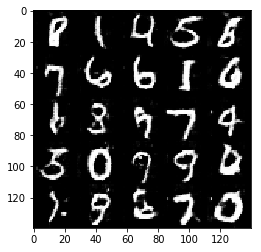

Epoch 2/2... Discriminator Loss: 0.8755... Generator Loss: 0.9192
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 0.5740
Epoch 2/2... Discriminator Loss: 1.2642... Generator Loss: 1.3019
Epoch 2/2... Discriminator Loss: 1.0838... Generator Loss: 0.6871
Epoch 2/2... Discriminator Loss: 1.1224... Generator Loss: 0.6849
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 0.7727
Epoch 2/2... Discriminator Loss: 1.4721... Generator Loss: 0.3701
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 0.7201
Epoch 2/2... Discriminator Loss: 1.0658... Generator Loss: 1.1037
Epoch 2/2... Discriminator Loss: 1.1868... Generator Loss: 0.6353


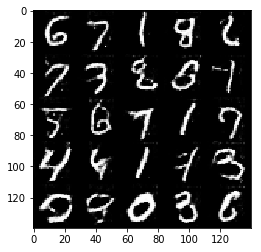

Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.5419
Epoch 2/2... Discriminator Loss: 0.8560... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.6381
Epoch 2/2... Discriminator Loss: 1.3085... Generator Loss: 0.4887
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.9028
Epoch 2/2... Discriminator Loss: 1.0259... Generator Loss: 0.6483
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.7709
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 1.0497
Epoch 2/2... Discriminator Loss: 1.2542... Generator Loss: 0.6790


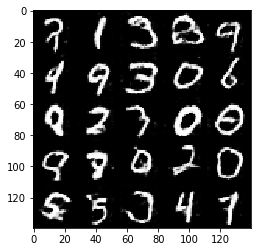

Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 0.5964
Epoch 2/2... Discriminator Loss: 0.9292... Generator Loss: 0.9627
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 1.0707... Generator Loss: 0.6814
Epoch 2/2... Discriminator Loss: 0.9817... Generator Loss: 0.8064
Epoch 2/2... Discriminator Loss: 0.9715... Generator Loss: 1.2390
Epoch 2/2... Discriminator Loss: 1.1670... Generator Loss: 0.6315
Epoch 2/2... Discriminator Loss: 0.9413... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 1.8591... Generator Loss: 0.2644
Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.6068


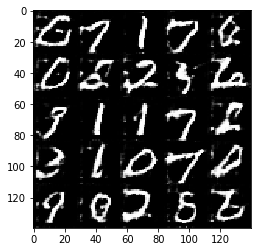

Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 0.8249
Epoch 2/2... Discriminator Loss: 1.2149... Generator Loss: 0.6150
Epoch 2/2... Discriminator Loss: 0.9507... Generator Loss: 1.0591
Epoch 2/2... Discriminator Loss: 1.3350... Generator Loss: 0.5315
Epoch 2/2... Discriminator Loss: 0.8509... Generator Loss: 0.7646
Epoch 2/2... Discriminator Loss: 1.0096... Generator Loss: 0.6760
Epoch 2/2... Discriminator Loss: 1.0927... Generator Loss: 1.3089
Epoch 2/2... Discriminator Loss: 1.1506... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 1.3404... Generator Loss: 0.4533
Epoch 2/2... Discriminator Loss: 1.4319... Generator Loss: 0.6726


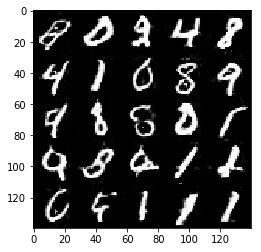

Epoch 2/2... Discriminator Loss: 1.0239... Generator Loss: 0.8188
Epoch 2/2... Discriminator Loss: 1.0360... Generator Loss: 0.7632
Epoch 2/2... Discriminator Loss: 1.1279... Generator Loss: 0.8154
Epoch 2/2... Discriminator Loss: 0.8749... Generator Loss: 1.0847
Epoch 2/2... Discriminator Loss: 0.9464... Generator Loss: 0.8299


In [12]:
# Use the same hyperparameters we used for the last GAN training exercise, from the
# Radford et al paper

batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 1.9818
Epoch 1/1... Discriminator Loss: 0.1393... Generator Loss: 3.0253
Epoch 1/1... Discriminator Loss: 0.1407... Generator Loss: 2.5855
Epoch 1/1... Discriminator Loss: 0.0837... Generator Loss: 3.1789
Epoch 1/1... Discriminator Loss: 0.1304... Generator Loss: 3.4592
Epoch 1/1... Discriminator Loss: 0.0757... Generator Loss: 3.1644
Epoch 1/1... Discriminator Loss: 0.0497... Generator Loss: 5.0641
Epoch 1/1... Discriminator Loss: 0.5027... Generator Loss: 0.9616
Epoch 1/1... Discriminator Loss: 0.5358... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 0.7793... Generator Loss: 0.7202


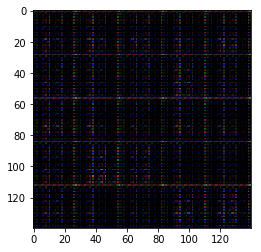

Epoch 1/1... Discriminator Loss: 0.5614... Generator Loss: 2.6983
Epoch 1/1... Discriminator Loss: 1.8030... Generator Loss: 0.3069
Epoch 1/1... Discriminator Loss: 0.3779... Generator Loss: 2.0352
Epoch 1/1... Discriminator Loss: 0.3716... Generator Loss: 1.7278
Epoch 1/1... Discriminator Loss: 1.9617... Generator Loss: 0.2746
Epoch 1/1... Discriminator Loss: 0.7146... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 0.7256... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 3.7342... Generator Loss: 0.0326
Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 1.2223... Generator Loss: 0.6410


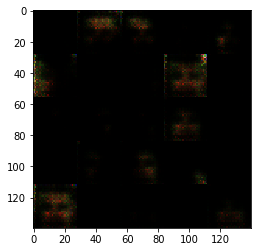

Epoch 1/1... Discriminator Loss: 1.0693... Generator Loss: 1.7682
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.7222... Generator Loss: 0.4851
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.8885
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.9546
Epoch 1/1... Discriminator Loss: 1.8527... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.2168


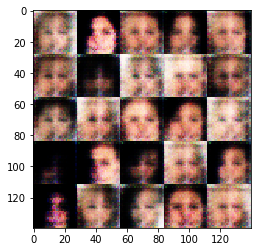

Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.8347
Epoch 1/1... Discriminator Loss: 1.7649... Generator Loss: 0.8038
Epoch 1/1... Discriminator Loss: 1.6668... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.9741... Generator Loss: 0.2589
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.8357... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.2295... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.6531... Generator Loss: 0.5788
Epoch 1/1... Discriminator Loss: 1.7326... Generator Loss: 0.4723


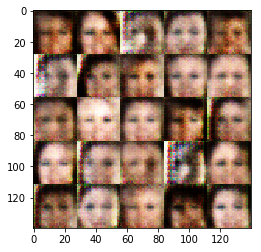

Epoch 1/1... Discriminator Loss: 1.0829... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.8279... Generator Loss: 0.3641
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7613
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.5952... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 1.6391... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.9277... Generator Loss: 0.3664
Epoch 1/1... Discriminator Loss: 1.6768... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6376


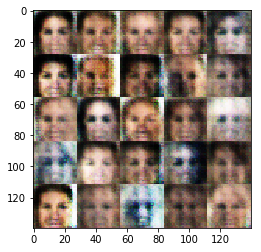

Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7469
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.4144... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.6136
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.7243


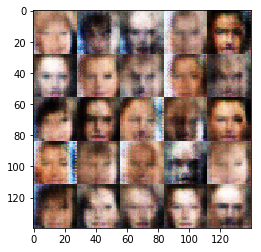

Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.7857
Epoch 1/1... Discriminator Loss: 1.3105... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7194
Epoch 1/1... Discriminator Loss: 1.5029... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.3706... Generator Loss: 0.7386


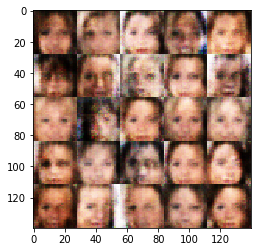

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7232
Epoch 1/1... Discriminator Loss: 1.5661... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6476


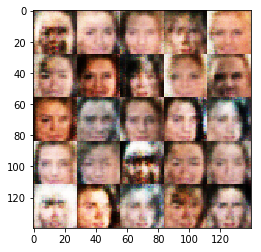

Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6618
Epoch 1/1... Discriminator Loss: 1.5369... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.7027
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7125
Epoch 1/1... Discriminator Loss: 1.4908... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7372


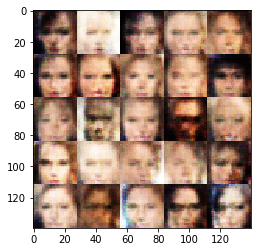

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.4477... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.3827... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.4162... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.6695


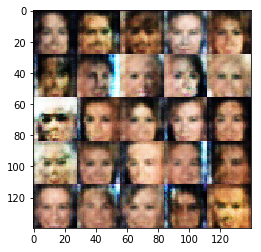

Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6987
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.5476... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6420
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6811
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6235


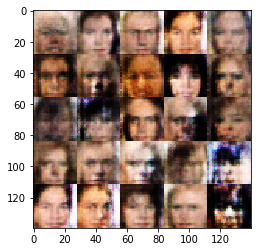

Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.4860... Generator Loss: 0.6810
Epoch 1/1... Discriminator Loss: 1.4793... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.3043... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.6410
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6679


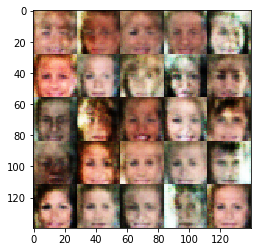

Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.4655... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6500
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.6854


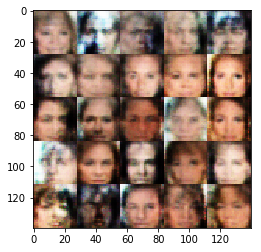

Epoch 1/1... Discriminator Loss: 1.4707... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6827
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.6208
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.6472
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.4006... Generator Loss: 0.6860
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.6321


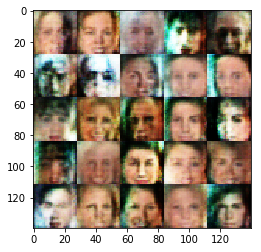

Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.5010... Generator Loss: 0.5894
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 0.6897
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6372


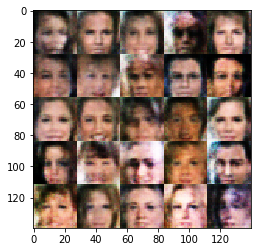

Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3758... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6577
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6218
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7072


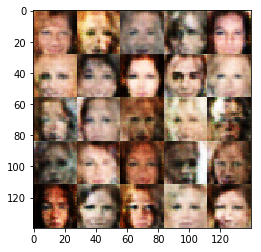

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.4729... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6990


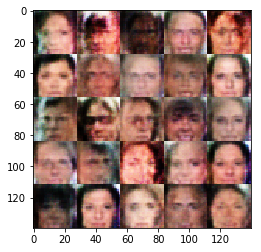

Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4826... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.3562... Generator Loss: 0.7130
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.5048... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.6311
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7104


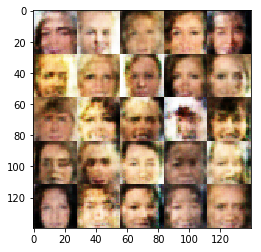

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.3491... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.5165... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6266


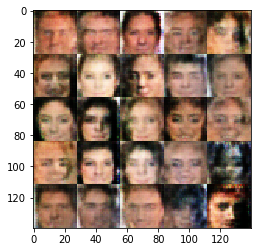

Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.6034
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.4401... Generator Loss: 0.6858


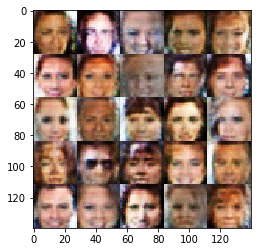

Epoch 1/1... Discriminator Loss: 1.4179... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3741... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.6524
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6170
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.6635


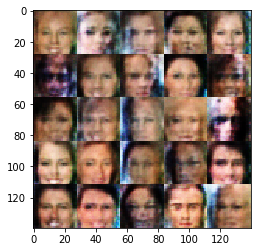

Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.6418
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.4341... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.4436... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6615
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6755
Epoch 1/1... Discriminator Loss: 1.4213... Generator Loss: 0.7224


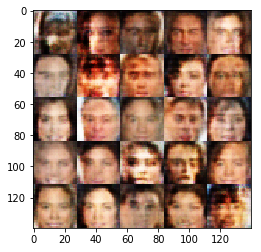

Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.4004... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.3649... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.7642


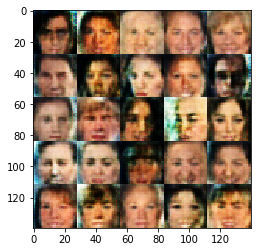

Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.4322... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4129... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.6773
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.7488


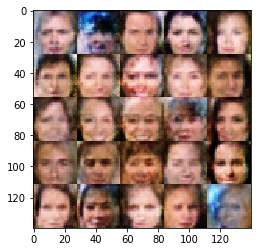

Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7099
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.7126
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.6598


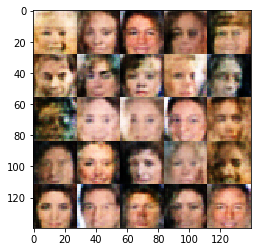

Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.7163
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7482
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.6758


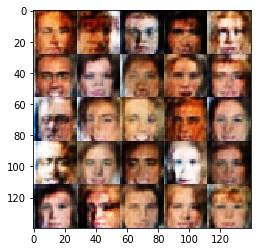

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7268
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.3629... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.5339... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7354


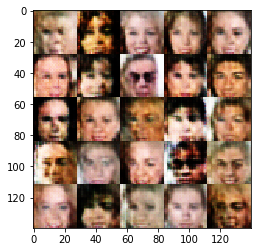

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.1978... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7854


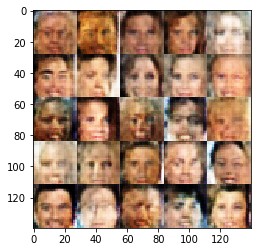

Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.4359... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.2644... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6226


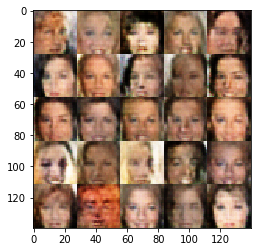

Epoch 1/1... Discriminator Loss: 1.3708... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.4365... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.5896
Epoch 1/1... Discriminator Loss: 1.3690... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3257... Generator Loss: 0.8521
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4721... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.6677


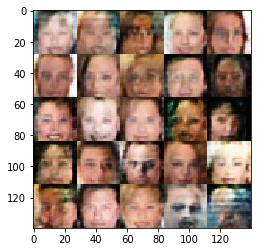

Epoch 1/1... Discriminator Loss: 1.3619... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6280
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.6901


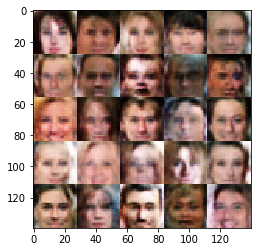

Epoch 1/1... Discriminator Loss: 1.4135... Generator Loss: 0.6128
Epoch 1/1... Discriminator Loss: 1.3770... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7181


In [13]:
# Use the same hyperparameters we used for the last GAN training exercise, from the
# Radford et al paper

batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)